In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [4]:
train_df.dtypes[train_df.dtypes != 'object']

PassengerId      int64
Survived         int64
Pclass           int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
dtype: object

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Survived', ylabel='Count'>

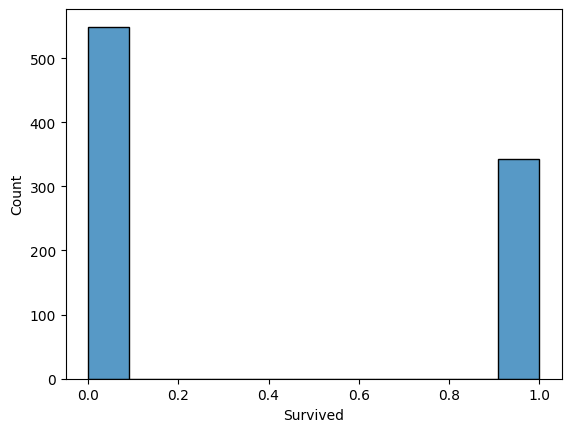

In [5]:
train_df['Survived'].value_counts()
sns.histplot(x='Survived', data=train_df)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Pclass', ylabel='Count'>

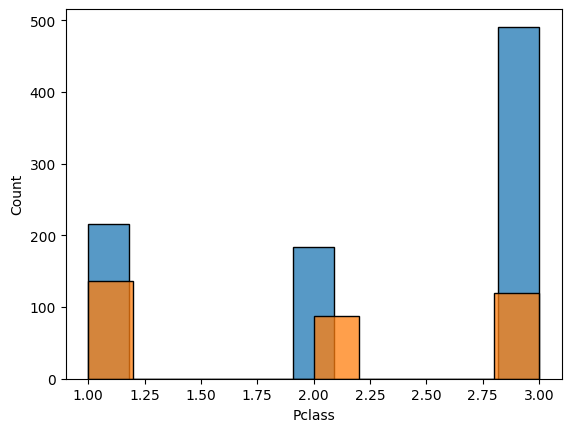

In [6]:
survived = train_df[train_df['Survived'] == 1]['Pclass'].value_counts()
not_survived = train_df[train_df['Survived'] == 0]['Pclass'].value_counts()
sns.histplot(x='Pclass',data=train_df, label='Overall Class Distribution')
sns.histplot(x='Pclass',data=train_df[train_df['Survived'] == 1], label='Survived in each Class')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

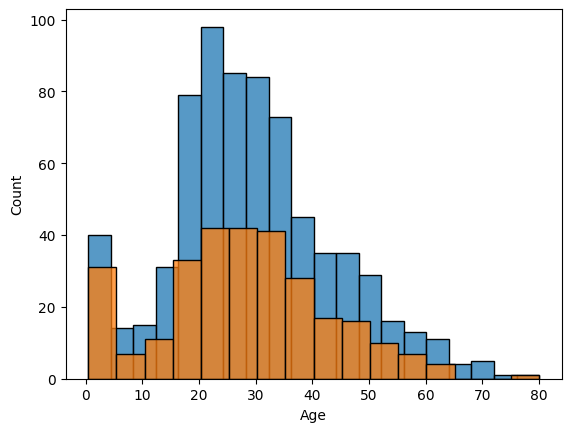

In [7]:
sns.histplot(x='Age',data=train_df, label='Overall Age Distribution')
sns.histplot(x='Age',data=train_df[train_df['Survived'] == 1], label='Survived by Age')

In [8]:
train_df[train_df['Age'].isnull()]['Survived'].value_counts()

Survived
0    125
1     52
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SibSp', ylabel='Count'>

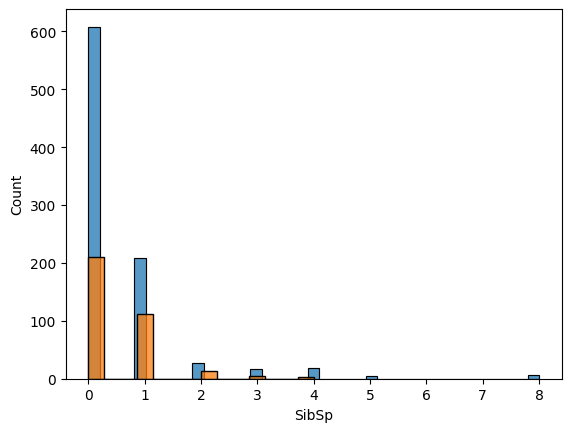

In [9]:
sns.histplot(x='SibSp',data=train_df, label='Overall SibSp Distribution')
sns.histplot(x='SibSp',data=train_df[train_df['Survived'] == 1], label='Survived by SibSp')

In [10]:
train_df.query('SibSp == 8')

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Parch', ylabel='Count'>

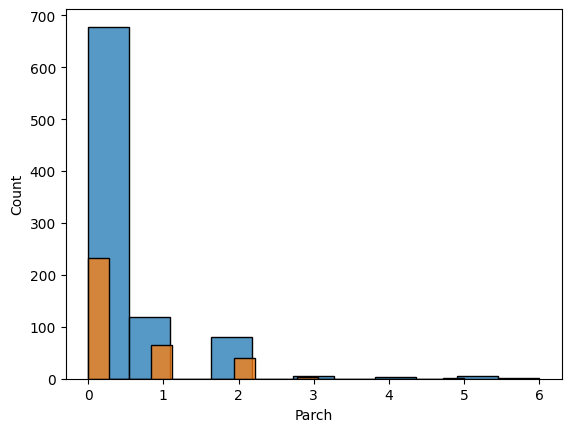

In [11]:
sns.histplot(x='Parch',data=train_df, label='Overall SibSp Distribution')
sns.histplot(x='Parch',data=train_df[train_df['Survived'] == 1], label='Survived by SibSp')

In [12]:

train_df.query('Fare == 0')

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


<Axes: >

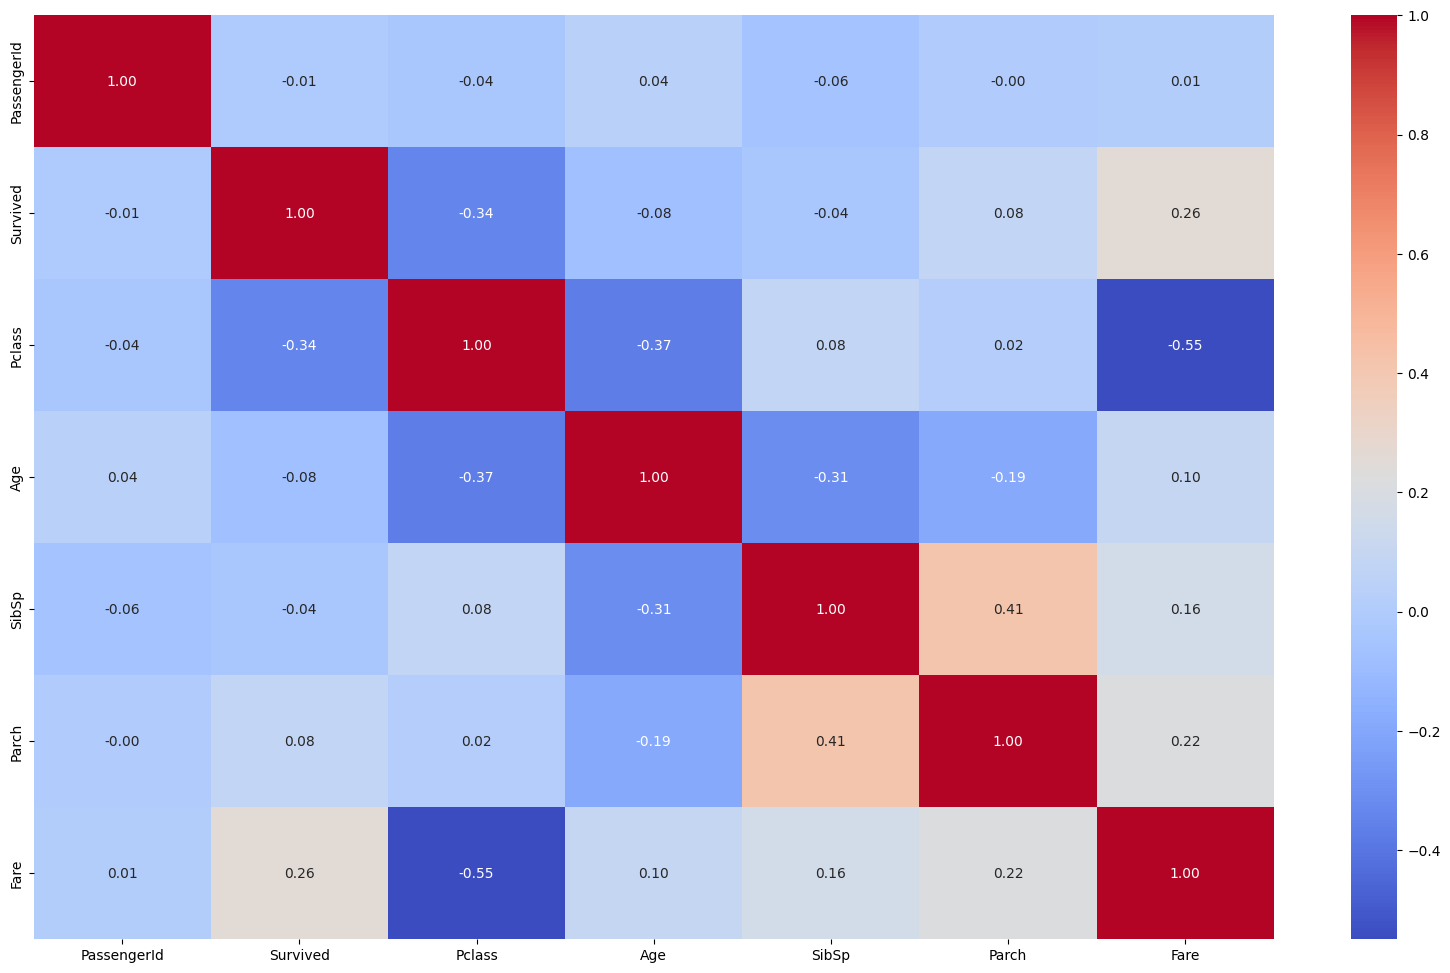

In [13]:
correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [14]:
train_df = train_df.drop(['Name', 'Ticket'], axis=1)
test_df = test_df.drop(['Name', 'Ticket'], axis=1)

In [15]:
train_df.dtypes[train_df.dtypes == 'object']

Sex         object
Cabin       object
Embarked    object
dtype: object

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Sex', ylabel='Count'>

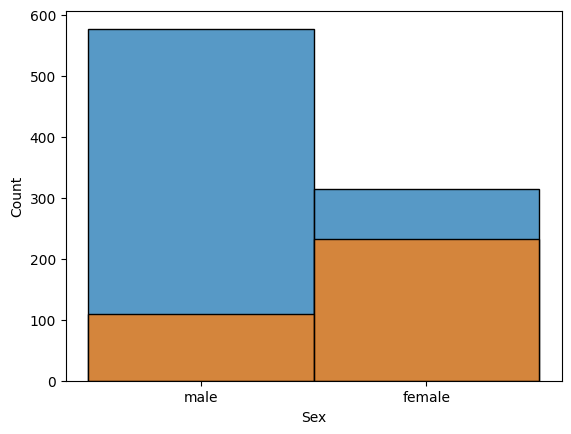

In [16]:
sns.histplot(x='Sex',data=train_df, label='Overall SibSp Distribution')
sns.histplot(x='Sex',data=train_df[train_df['Survived'] == 1], label='Survived by SibSp')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Embarked', ylabel='Count'>

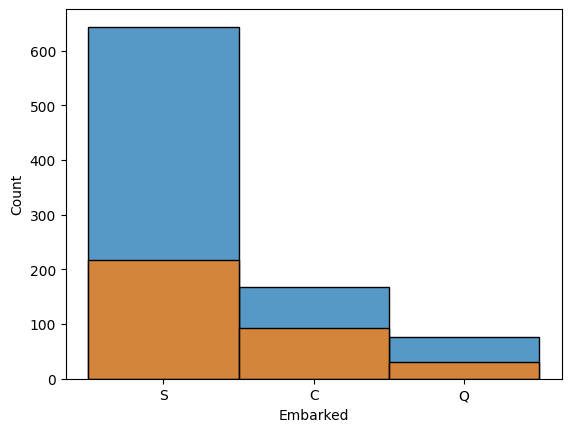

In [17]:
sns.histplot(x='Embarked',data=train_df, label='Overall SibSp Distribution')
sns.histplot(x='Embarked',data=train_df[train_df['Survived'] == 1], label='Survived by SibSp')

In [18]:
train_df['Family'] = train_df['SibSp'] + train_df['Parch']
test_df['Family'] = test_df['SibSp'] + test_df['Parch']
train_df = train_df.drop(['SibSp', 'Parch'], axis=1)
test_df = test_df.drop(['SibSp', 'Parch'], axis=1)

In [19]:
train_df["Cabin_missing"] = train_df["Cabin"].isnull().astype(int)
test_df["Cabin_missing"] = test_df["Cabin"].isnull().astype(int)

# train_df["Cabin_Deck"] = train_df["Cabin"].str[0]  # Extract first letter
# train_df["Cabin_Deck"].fillna("M", inplace=True)  # 'M' for missing

# test_df["Cabin_Deck"] = test_df["Cabin"].str[0]  # Extract first letter
# test_df["Cabin_Deck"].fillna("M", inplace=True)  # 'M' for missing

train_df = train_df.drop('Cabin', axis=1)
test_df = test_df.drop('Cabin', axis=1)

In [20]:
train_df = train_df.drop('PassengerId', axis=1)
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('Survived')

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [21]:
ohe_cols = ['Embarked', 
            # 'Cabin_Deck'
           ]
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [22]:
le = LabelEncoder()
train_df.Sex = le.fit_transform(train_df.Sex)
test_df.Sex = le.fit_transform(test_df.Sex)

In [23]:
ode_cols = ['Sex']
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent'))
])

In [24]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols)
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [25]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [26]:
X = train_df.drop(['Survived'], axis=1)
Y = train_df.Survived

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=25)

In [28]:
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [41]:
params_lgbm = {
    "num_leaves": [15],  # Reduce model complexity
    "max_depth": [2],  
    "min_data_in_leaf":[ 20],  # Prevent overfitting
    "subsample": [0.7],  # Randomly select 70% of data per tree
    "colsample_bytree": [0.8]
}

lgbm = lgb.LGBMClassifier(verbosity=-1, objective="binary", metric="auc", random_state=35)
lgbm_cv = GridSearchCV(lgbm, params_lgbm, cv=5, scoring="accuracy")
lgbm_cv.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(metric='auc', objective='binary',
                                      random_state=35, verbosity=-1),
             param_grid={'colsample_bytree': [0.8], 'max_depth': [2],
                         'min_data_in_leaf': [20], 'num_leaves': [15],
                         'subsample': [0.7]},
             scoring='accuracy')

In [47]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family,Cabin_missing
0,0,3,1,22.0,7.2500,S,1,1
1,1,1,0,38.0,71.2833,C,1,0
2,1,3,0,26.0,7.9250,S,0,1
3,1,1,0,35.0,53.1000,S,1,0
4,0,3,1,35.0,8.0500,S,0,1


In [42]:
print('train score', lgbm_cv.best_score_)
print('test score', lgbm_cv.score(X_test_preprocessed, y_test))
print('best params', lgbm_cv.best_params_)

from sklearn.model_selection import StratifiedKFold, cross_val_score

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgbm_cv, X_train_preprocessed, y_train, cv=kf, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())


train score 0.8203191175022161
test score 0.8324022346368715
best params {'colsample_bytree': 0.8, 'max_depth': 2, 'min_data_in_leaf': 20, 'num_leaves': 15, 'subsample': 0.7}
Cross-validation scores: [0.87412587 0.83916084 0.85211268 0.8028169  0.76760563]
Mean CV score: 0.8271643849108639


In [43]:
test_id = test_df[['PassengerId']]
test = test_df.drop('PassengerId', axis=1)

df_test_preprocess = pipeline.transform(test)
df_y_stacking_out = test_id
df_y_stacking_out['Survived'] = lgbm_cv.predict(df_test_preprocess)
df_y_stacking_out.to_csv('19submission.csv', index=False)
#lgbm rfc

<ipython-input-43-8cb5d404b312>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['Survived'] = lgbm_cv.predict(df_test_preprocess)
